In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [3]:
class Parameters():
    def __init__(self):
        self.description = 'Model for time-series forecasting'

        # Input sequence length - look-back
        self.Lag = 64
        # Prediction sequence length
        self.Horizon = 14
        #
        self.kernel_size = 25

        # Training parameters
        #
        # Number of epochs
        self.epochs = 10
        # Batch size
        self.batch_size = 32
        # Trained model path
        self.model_path = 'S_1.h5'

        # Data handling
        #
        # Filename
        self.train_file = './S_train.csv'
        self.test_file = './S_test.csv'
        # Target series name
        self.targetSeries = 'PM25_Concentration'
        # Scaling {'Standard', 'MinMax', 'Robust'}
        self.Scaling = 'MinMax'
        self.scalers_filename = "S.joblib"

args = Parameters()

In [4]:
# Start timer
#
start = time.time()

# Load data
#
df_train = pd.read_csv( args.train_file )
df_test = pd.read_csv( args.test_file )

print('[INFO] Data imported')

df_train["Unnamed: 0"] = df_train["Unnamed: 0"].astype('datetime64')
df_train.set_index("Unnamed: 0", inplace=True)
df_train.head(3)

[INFO] Data imported


,weather,temperature,pressure,humidity,wind_speed,wind_direction,PM10_Concentration,NO2_Concentration,CO_Concentration,O3_Concentration,SO2_Concentration,PM25_Concentration
Unnamed: 0,,,,,,,,,,,,
2014-10-29 11:00:00,1.0,0.794118,0.540984,0.53,0.034722,13.0,0.083333,0.111111,0.057218,0.193460,0.014028,29.0
2014-10-29 12:00:00,1.0,0.803922,0.524590,0.53,0.055556,13.0,0.050505,0.068376,0.057975,0.201635,0.010020,29.0
2014-10-29 13:00:00,1.0,0.811765,0.508197,0.52,0.034722,13.0,0.050505,0.055556,0.054005,0.204360,0.010020,28.0


In [5]:
df_test["Unnamed: 0"] = df_test["Unnamed: 0"].astype('datetime64')
df_test.set_index("Unnamed: 0", inplace=True)
df_test.head(3)

,weather,temperature,pressure,humidity,wind_speed,wind_direction,PM10_Concentration,NO2_Concentration,CO_Concentration,O3_Concentration,SO2_Concentration,PM25_Concentration
Unnamed: 0,,,,,,,,,,,,
2015-03-25 06:00:00,2.0,0.570588,0.631148,0.76,0.013889,13.0,0.050505,0.029915,0.041591,0.226158,0.010020,24.0
2015-03-25 07:00:00,2.0,0.570588,0.639344,0.75,0.013889,13.0,0.074495,0.064103,0.042851,0.182561,0.012024,30.0
2015-03-25 08:00:00,2.0,0.570588,0.639344,0.75,0.013889,13.0,0.074495,0.064103,0.042851,0.182561,0.012024,30.0


In [6]:
scalers = {}

if (args.Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')

    for feature in df_train.columns:
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = MinMaxScaler()

        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        scalers[feature] = scaler

elif (args.Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')

    for feature in df_train.columns:
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = RobustScaler()

        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

elif (args.Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    for feature in df_train.columns:
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()

        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

else:
    print('[WARNING] Unknown data scaling.')

joblib.dump(scalers, args.scalers_filename)
print(f"All scalers saved to {args.scalers_filename}")


[INFO] Scaling: MinMax
Feature:  weather
Feature:  temperature
Feature:  pressure
Feature:  humidity
Feature:  wind_speed
Feature:  wind_direction
Feature:  PM10_Concentration
Feature:  NO2_Concentration
Feature:  CO_Concentration
Feature:  O3_Concentration
Feature:  SO2_Concentration
Feature:  PM25_Concentration
All scalers saved to S.joblib


In [7]:
def create_dataset(df, targetSeries, Lag = 1, Horizon = 1):

    dataX, dataY, dataDate = [], [], []
    # dfX = df.drop(targetSeries, axis=1)
    dfY = df[targetSeries]

    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon) ):

        dataX.append( df.to_numpy()[i:(i+Lag)] )
        dataY.append( dfY.to_numpy()[i + Lag : i + Lag + Horizon] )
        dataDate.append( df.index[i + Lag : i + Lag + Horizon].tolist() )

    return ( np.array(dataX), np.array(dataY), np.array(dataDate) )

In [8]:
trainX, trainY, _ = create_dataset(df = df_train,
                                   Lag = args.Lag,
                                   Horizon = args.Horizon,
                                   targetSeries = args.targetSeries)


testX, testY, testDate = create_dataset(df = df_test,
                                          Lag = args.Lag,
                                          Horizon = args.Horizon,
                                          targetSeries = args.targetSeries)

trainY = np.expand_dims(trainY, axis = -1)
testY  = np.expand_dims(testY,  axis = -1)

print('\nTraining data shape:   ', trainX.shape, trainY.shape)
print('Testing data shape:    ', testX.shape,  testY.shape)

100%|██████████| 781/781 [00:00<00:00, 19352.00it/s]



Training data shape:    (3446, 64, 12) (3446, 14, 1)
Testing data shape:     (781, 64, 12) (781, 14, 1)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

from tensorflow.keras.models import *

In [11]:
def model1():
    inputs = layers.Input(shape=(args.Lag, 12))
    trend_init = layers.AveragePooling1D(pool_size=args.kernel_size, strides=1, padding='same')(inputs)
    seasonal_init = inputs - trend_init

    encoder_1 = layers.LSTM(64, return_state=True)
    encoder_2 = layers.LSTM(64, return_state=True)
    encoder_outputs1 = encoder_1(seasonal_init)
    encoder_outputs2 = encoder_2(trend_init)

    decoder_inputs1 = layers.RepeatVector(args.Horizon)(encoder_outputs1[0])
    decoder_inputs2 = layers.RepeatVector(args.Horizon)(encoder_outputs2[0])

    decoder_outputs1 = layers.TimeDistributed(layers.Dense(1))(decoder_inputs1)
    decoder_outputs2 = layers.TimeDistributed(layers.Dense(1))(decoder_inputs2)

    model = Model(inputs, decoder_outputs1+decoder_outputs2)
    return model


In [12]:
def model2():
    inputs = layers.Input(shape=(args.Lag, 12))
    trend_init = layers.AveragePooling1D(pool_size=args.kernel_size, strides=1, padding='same')(inputs)
    seasonal_init = inputs - trend_init

    encoder_1 = layers.LSTM(64, return_state=True)
    encoder_2 = layers.LSTM(64, return_state=True)
    encoder_outputs1 = encoder_1(seasonal_init)
    encoder_outputs2 = encoder_2(trend_init)

    encoder_states1 = encoder_outputs1[1:]
    encoder_states2 = encoder_outputs2[1:]

    decoder_inputs1 = layers.RepeatVector(args.Horizon)(encoder_outputs1[0])
    decoder_inputs2 = layers.RepeatVector(args.Horizon)(encoder_outputs2[0])

    decoder_1 = layers.LSTM(64, return_sequences=True)(decoder_inputs1,initial_state = encoder_states1)
    decoder_2 = layers.LSTM(64, return_sequences=True)(decoder_inputs2,initial_state = encoder_states2)
    decoder_outputs1 = layers.TimeDistributed(layers.Dense(1))(decoder_1)
    decoder_outputs2 = layers.TimeDistributed(layers.Dense(1))(decoder_2)

    model = Model(inputs, decoder_outputs1+decoder_outputs2)
    return model

In [13]:
model = model1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 12)]             0         []                            
                                                                                                  
 average_pooling1d (Average  (None, 64, 12)               0         ['input_1[0][0]']             
 Pooling1D)                                                                                       
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 64, 12)               0         ['input_1[0][0]',             
 da)                                                                 'average_pooling1d[0][0]']   
                                                                                              

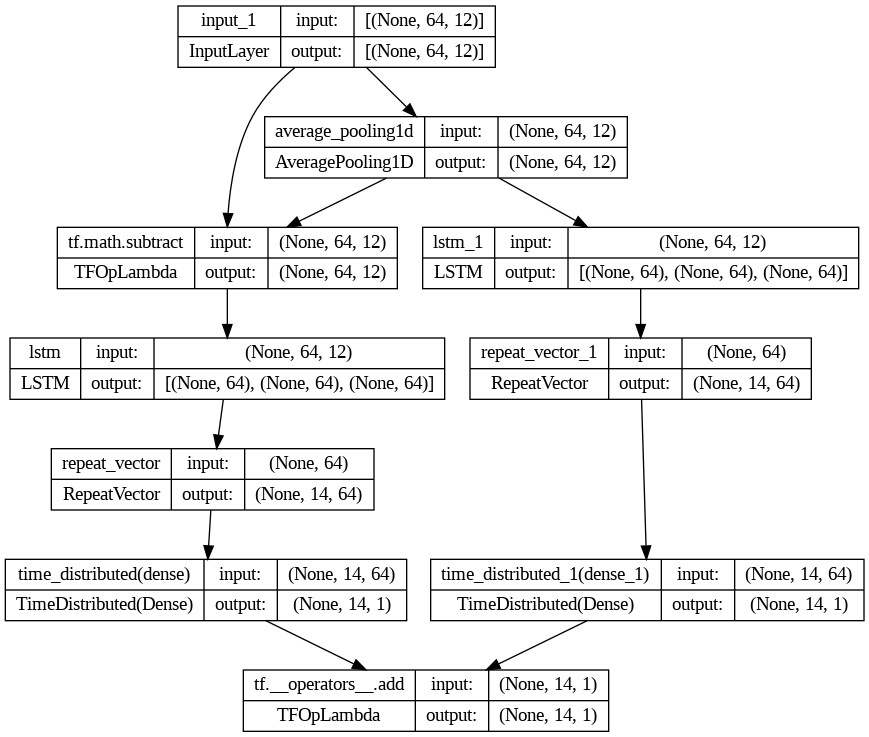

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [16]:
model.fit([trainX], trainY, epochs=args.epochs, batch_size=args.batch_size)

Epoch 1/10
108/108 [==============================] - 11s 61ms/step - loss: 0.0095 - mae: 0.0679
Epoch 2/10
108/108 [==============================] - 5s 50ms/step - loss: 0.0066 - mae: 0.0564
Epoch 3/10
108/108 [==============================] - 5s 46ms/step - loss: 0.0064 - mae: 0.0555
Epoch 4/10
108/108 [==============================] - 7s 65ms/step - loss: 0.0062 - mae: 0.0544
Epoch 5/10
108/108 [==============================] - 5s 46ms/step - loss: 0.0060 - mae: 0.0538
Epoch 6/10
108/108 [==============================] - 7s 65ms/step - loss: 0.0056 - mae: 0.0521
Epoch 7/10
108/108 [==============================] - 5s 50ms/step - loss: 0.0052 - mae: 0.0512
Epoch 8/10
108/108 [==============================] - 5s 47ms/step - loss: 0.0049 - mae: 0.0494
Epoch 9/10
108/108 [==============================] - 7s 65ms/step - loss: 0.0045 - mae: 0.0484
Epoch 10/10
108/108 [==============================] - 5s 46ms/step - loss: 0.0046 - mae: 0.0488


In [17]:
model.save(args.model_path)

In [18]:
loss, mae = model.evaluate(testX, testY)
print("Mean Square Error:", loss)
print("Mean Absolute Error:", mae)

25/25 [==============================] - 1s 16ms/step - loss: 0.0054 - mae: 0.0542
Mean Square Error: 0.005376954562962055
Mean Absolute Error: 0.05421728640794754
